### 1. 数据获取

In [1]:
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import warnings

# 让matplotlib库正常显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用于正常显示负号

#### 1.1 AKShare

In [2]:
print(f"Current AKShare Version: {ak.__version__}")

Current AKShare Version: 1.16.74


**获取期货交易所与品种信息**:
- AKSahre中不同交易所简称约定
- 
| 交易所 | code |
|:-----:|:----:|
| 上海期货交易所 | SHFE |
|郑州商品交易所|CZCE|
|广州期货交易所|GFEX|
|大连商品交易所|DCE|
|中国金融期货交易所|CFFEX|
|上海国际能源交易中心|INE|

- `futures_contract_info_<code>(date="20250410")`: 获取当前交易日下\<code\>交易所的所有合约信息
- `futures_rules(date="20250410")`: 获取当前交易日下**所有**交易所的所有**品种**信息

In [3]:
from collections import defaultdict
# 获取交易所期货品种
def get_futures_varieties(date=None):
    if date is None:
        date = datetime.today().strftime("%Y%m%d")
    
    # download data
    data = ak.futures_rule(date=date)
    agencies = data["交易所"].unique().tolist()
    
    result = {agent: defaultdict(list) for agent in agencies}
    
    for agency in agencies:
        temp = data[data["交易所"]==agency]
        for idx, row in temp.iterrows():
            result[agency][row["品种"]] = [row["品种"],row["代码"],row["最小变动价位"], row["合约乘数"]]
    
    return result

# 获取期货交易所品种
futures_varieties = get_futures_varieties()
# print
for k,v in futures_varieties.items():
    print(f"交易所 -> {k}")
    for kk, vv in futures_varieties[k].items():
        if "期权" in kk or "国债" in kk:
            continue
        print(f"品种: {kk}, 代码: {vv[1]:}, 每单位最小变动价位: {vv[2]}, 每手成交单位:{vv[3]}单位/手")

交易所 -> 上期所
品种: 铜, 代码: CU, 每单位最小变动价位: 10.0, 每手成交单位:5单位/手
品种: 铝, 代码: AL, 每单位最小变动价位: 5.0, 每手成交单位:5单位/手
品种: 锌, 代码: ZN, 每单位最小变动价位: 5.0, 每手成交单位:5单位/手
品种: 铅, 代码: PB, 每单位最小变动价位: 5.0, 每手成交单位:5单位/手
品种: 镍, 代码: NI, 每单位最小变动价位: 10.0, 每手成交单位:1单位/手
品种: 锡, 代码: SN, 每单位最小变动价位: 10.0, 每手成交单位:1单位/手
品种: 不锈钢, 代码: SS, 每单位最小变动价位: 5.0, 每手成交单位:5单位/手
品种: 螺纹钢, 代码: RB, 每单位最小变动价位: 1.0, 每手成交单位:10单位/手
品种: 热轧卷板, 代码: HC, 每单位最小变动价位: 1.0, 每手成交单位:10单位/手
品种: 线材, 代码: WR, 每单位最小变动价位: 1.0, 每手成交单位:10单位/手
品种: 黄金, 代码: AU, 每单位最小变动价位: 0.02, 每手成交单位:1000单位/手
品种: 白银, 代码: AG, 每单位最小变动价位: 1.0, 每手成交单位:15单位/手
品种: 丁二烯橡胶, 代码: BR, 每单位最小变动价位: 5.0, 每手成交单位:5单位/手
品种: 天然橡胶, 代码: RU, 每单位最小变动价位: 5.0, 每手成交单位:10单位/手
品种: 燃料油, 代码: FU, 每单位最小变动价位: 1.0, 每手成交单位:10单位/手
品种: 石油沥青, 代码: BU, 每单位最小变动价位: 1.0, 每手成交单位:10单位/手
品种: 纸浆, 代码: SP, 每单位最小变动价位: 2.0, 每手成交单位:10单位/手
品种: 氧化铝, 代码: AO, 每单位最小变动价位: 1.0, 每手成交单位:20单位/手
交易所 -> 能源中心
品种: 原油, 代码: SC, 每单位最小变动价位: 0.1, 每手成交单位:1000单位/手
品种: 低硫燃料油, 代码: LU, 每单位最小变动价位: 1.0, 每手成交单位:10单位/手
品种: 20号胶, 代码: NR, 每单位最小变动价位: 5.0, 每手成交单位:10单位/手

**获取主力合约行情**

- `futures_main_sina(symbol=主力合约品种名, start_date=20250408, end_date=20250410)`： 返回每日的开盘、收盘、最高、最低、成交和持仓
- `ak.futures_display_main_sina()`：获取新浪财经接口主力连续合约品种一览表


In [4]:
## 3. 获取期货主力合约行情数据

def get_futures_daily_data(symbol, start_date, end_date=None):
    """
    获取期货主力合约日线数据
    
    参数:
    symbol (str): 期货代码，如'RB'（螺纹钢）,'IF'（沪深300股指期货）
    start_date (str): 开始日期，格式为'YYYYMMDD'
    end_date (str): 结束日期，格式为'YYYYMMDD'，默认为当前日期
    
    返回:
    pandas.DataFrame: 包含期货日线数据的DataFrame
    """
    if end_date is None:
        end_date = datetime.today().strftime('%Y%m%d')
    
    #print("新浪财经接口的主力连续合约如下:(代码均0结尾)")     
    #main_contract_names = ak.futures_display_main_sina() 
    #print(main_contract_names.to_string(
    #    justify='center',
    #    max_rows=10,
    #    float_format="%.2f"
    #))   
    
    try:
        # 获取期货主力合约数据
        df = ak.futures_main_sina(symbol=symbol, start_date=start_date, end_date=end_date)
        df = df.rename(columns={
            '日期': 'date',
            '开盘价': 'open',
            '最高价': 'high',
            '最低价': 'low',
            '收盘价': 'close',
            '成交量': 'volume',
            '持仓量': 'open_interest'
        })
        return df
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return pd.DataFrame()

# 示例：获取螺纹钢主力合约近一年数据
start_date = (datetime.now() - timedelta(days=60)).strftime('%Y%m%d')
rb_data = get_futures_daily_data("RB0", start_date)

if not rb_data.empty:
    print("\n螺纹钢主力合约数据预览:")
    display(rb_data.head(10))
    
    # 数据处理：转换日期格式，并设置为索引
    rb_data['date'] = pd.to_datetime(rb_data['date'])
    rb_data.set_index('date', inplace=True)
    
    print(f"\n数据时间范围: {rb_data.index.min().date()} 至 {rb_data.index.max().date()}")
    print(f"数据条数: {len(rb_data)}")
else:
    print("未获取到螺纹钢数据")


螺纹钢主力合约数据预览:


,date,open,high,low,close,volume,open_interest,动态结算价
0,2025-02-10,3355,3374,3312,3331,1851664,1856963,3340
1,2025-02-11,3339,3339,3269,3275,1803197,1947395,3302
2,2025-02-12,3275,3297,3261,3292,1274350,1895628,3280
3,2025-02-13,3292,3299,3255,3265,1297857,1889839,3277
4,2025-02-14,3260,3288,3252,3262,1124905,1885541,3268
5,2025-02-17,3259,3301,3247,3290,1400224,1902224,3269
6,2025-02-18,3289,3320,3276,3313,1316289,1880432,3299
7,2025-02-19,3318,3329,3308,3315,911004,1860033,3317
8,2025-02-20,3311,3364,3305,3358,1572547,1924251,3331
9,2025-02-21,3358,3377,3356,3361,1237733,1937278,3366



数据时间范围: 2025-02-10 至 2025-04-10
数据条数: 43


**获取多品种期货数据**



In [5]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_multi_futures_data(symbols, start_date, end_date=None):
    """
    获取多个期货品种的主力合约数据
    
    参数:
    symbols (list): 期货代码列表
    start_date (str): 开始日期
    end_date (str): 结束日期
    
    返回:
    dict: 包含各品种数据的字典
    """
    if end_date is None:
        end_date = datetime.now().strftime('%Y%m%d')
    
    pbar = tqdm(total=len(symbols), desc="获取期货数据", unit="品种")
    
    def _fetch_single(symbol):
        try:
            data = get_futures_daily_data(symbol,start_date, end_date=end_date)
            if not data.empty:
                # print(1)
                data['symbol'] = symbol.rstrip("0")
                return symbol, data
        except Exception as e:
            print(f"\n{symbol} 数据获取异常: {str(e)}")
        finally:
            pbar.update(1)
        return symbol, pd.DataFrame()
    
    all_data = {}
    with ThreadPoolExecutor(max_workers=2) as executor:
        # submit 
        future_to_submit = {
            executor.submit(_fetch_single, sym): sym
            for sym in symbols
        }
        
        for future in as_completed(future_to_submit):
            
            try:
                symbol, data = future.result()
                if not data.empty:
                    all_data[symbol] = data
            except Exception as e:
                print(e)
    
    return all_data

# 选择几个代表性的期货品种
selected_symbols = ["RB0", "IF0","CU0", "AU0"]  # 螺纹钢、沪深300、黄金、铜、豆粕

# 获取多品种数据
multi_futures_data = get_multi_futures_data(selected_symbols, start_date)

for k,vvv in multi_futures_data.items():
    v=vvv.copy()
    print(f"品种 -> {k}")
    display(v.head())
    # 数据处理：转换日期格式，并设置为索引
    v['date'] = pd.to_datetime(v['date'])
    v.set_index('date', inplace=True)
    
    print(f"\n数据时间范围: {v.index.min().date()} 至 {v.index.max().date()}")
    print(f"数据条数: {len(v)}")
    print("="*10)

获取期货数据: 100%|██████████| 4/4 [00:01<00:00,  2.21品种/s]

品种 -> IF0


,date,open,high,low,close,volume,open_interest,动态结算价,symbol
0,2025-02-10,3905.0,3910.2,3882.2,3899.0,64008,159057,0.0,IF
1,2025-02-11,3902.0,3904.4,3868.4,3883.2,54628,157204,0.0,IF
2,2025-02-12,3879.0,3927.6,3866.0,3918.4,74891,160158,0.0,IF
3,2025-02-13,3914.6,3940.2,3901.0,3910.0,82808,162824,0.0,IF
4,2025-02-14,3912.8,3948.6,3904.4,3944.4,79613,160292,0.0,IF



数据时间范围: 2025-02-10 至 2025-04-10
数据条数: 43
品种 -> RB0


,date,open,high,low,close,volume,open_interest,动态结算价,symbol
0,2025-02-10,3355,3374,3312,3331,1851664,1856963,3340,RB
1,2025-02-11,3339,3339,3269,3275,1803197,1947395,3302,RB
2,2025-02-12,3275,3297,3261,3292,1274350,1895628,3280,RB
3,2025-02-13,3292,3299,3255,3265,1297857,1889839,3277,RB
4,2025-02-14,3260,3288,3252,3262,1124905,1885541,3268,RB



数据时间范围: 2025-02-10 至 2025-04-10
数据条数: 43
品种 -> CU0


,date,open,high,low,close,volume,open_interest,动态结算价,symbol
0,2025-02-10,77360,77950,76950,77370,105092,183381,77400,CU
1,2025-02-11,77410,77650,76920,77150,68212,180965,77280,CU
2,2025-02-12,76750,77060,76530,77000,68470,181216,76790,CU
3,2025-02-13,77100,77730,76930,77560,74373,182755,77400,CU
4,2025-02-14,77500,78330,77120,78090,84534,183353,77810,CU



数据时间范围: 2025-02-10 至 2025-04-10
数据条数: 43
品种 -> AU0


,date,open,high,low,close,volume,open_interest,动态结算价,symbol
0,2025-02-10,670.50,679.50,668.20,679.08,371683,201628,673.66,AU
1,2025-02-11,682.22,691.76,679.84,685.74,411548,193611,684.58,AU
2,2025-02-12,680.00,685.12,677.00,681.22,354672,184046,681.42,AU
3,2025-02-13,679.72,686.48,675.12,684.56,359774,186366,681.68,AU
4,2025-02-14,685.72,688.66,683.86,688.40,254378,190905,686.22,AU



数据时间范围: 2025-02-10 至 2025-04-10
数据条数: 43


**OHLCV数据结构解析与可视化**

- `Series.pct_chage`: 当前值-前值 / 前值
- `Series.cumprod()`: 累计乘积
- `Series.cummax()`: 累计给出当前及之前的最大值

In [6]:
def analyze_futures_data(data1, symbol):
    """分析期货OHLCV数据并生成基本统计信息"""
    # 计算基本统计量
    data = data1.copy()
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    
    data['daily_return']= data['close'].pct_change()
    data['cumulative_return'] = (1+data['daily_return']).cumprod()-1
    
    stats = {
        '品种代码': symbol.rstrip('0'),
        '起始日期': data.index[0].strftime('%Y-%m-%d'),
        '结束日期': data.index[-1].strftime('%Y-%m-%d'),
        '交易天数': len(data),
        '价格区间': f"{data['low'].min():.2f} - {data['high'].max():.2f}",
        '平均价': data['close'].mean(),
        '年化波动率 (%)': data['close'].pct_change().std() * 100 * np.sqrt(252),  # 年化波动率
        '成交量分析': {
            '总量（万手）': data['volume'].sum() / 10000,
            '日均量（万手）': data['volume'].mean() / 10000,
            '最大单日量（万手）': data['volume'].max() / 10000
        },
        '持仓趋势': {
            '期初持仓': data['open_interest'].iloc[0],
            '期末持仓': data['open_interest'].iloc[-1],
            '持仓变化率 (%)': (data['open_interest'].iloc[-1] - data['open_interest'].iloc[0]) / data['open_interest'].iloc[0] * 100
        },
        '收益分析': {
            '总收益率 (%)': (data['close'].iloc[-1] - data['close'].iloc[0]) / data['close'].iloc[0] * 100,
            '最大回撤 (%)': (data['cumulative_return'].cummax() - data['cumulative_return']).max() * 100,
            '夏普比率': data['daily_return'].mean() / data['daily_return'].std() * np.sqrt(252)
        }
    }
    
    # 格式化输出
    print(f"\n{'='*30} {stats['品种代码']}期货分析报告 {'='*30}")
    for category, values in stats.items():
        if category in ['品种代码', '起始日期', '结束日期']:
            continue
        print(f"\n▌ {category}:")
        if isinstance(values, dict):
            for k, v in values.items():
                if isinstance(v, float):
                    print(f"  ├─ {k}: {v:.2f}")
                else:
                    print(f"  ├─ {k}: {v}")
        else:
            print(f"  {values}")
    
    return data

# 分析螺纹钢数据
if 'RB0' in multi_futures_data:
    rb_analyzed = analyze_futures_data(multi_futures_data['RB0'], 'RB0')


============================== RB期货分析报告 ==============================

▌ 交易天数:
  43

▌ 价格区间:
  3033.00 - 3377.00

▌ 平均价:
  3240.9302325581393

▌ 年化波动率 (%):
  16.559219485191626

▌ 成交量分析:
  ├─ 总量（万手）: 6858.83
  ├─ 日均量（万手）: 159.51
  ├─ 最大单日量（万手）: 266.64

▌ 持仓趋势:
  ├─ 期初持仓: 1856963
  ├─ 期末持仓: 1686421
  ├─ 持仓变化率 (%): -9.18

▌ 收益分析:
  ├─ 总收益率 (%): -5.76
  ├─ 最大回撤 (%): 8.20
  ├─ 夏普比率: -2.07


- `Figure.add_gridspec()`: 可以将画布分割成不同的区域小块
- `Figure.add_subplot(网格的区域)`: 将上一步的网格区域，挑选指定的区域添加一副图
- add_subplot的sharex参数指定和哪幅子图共享x轴

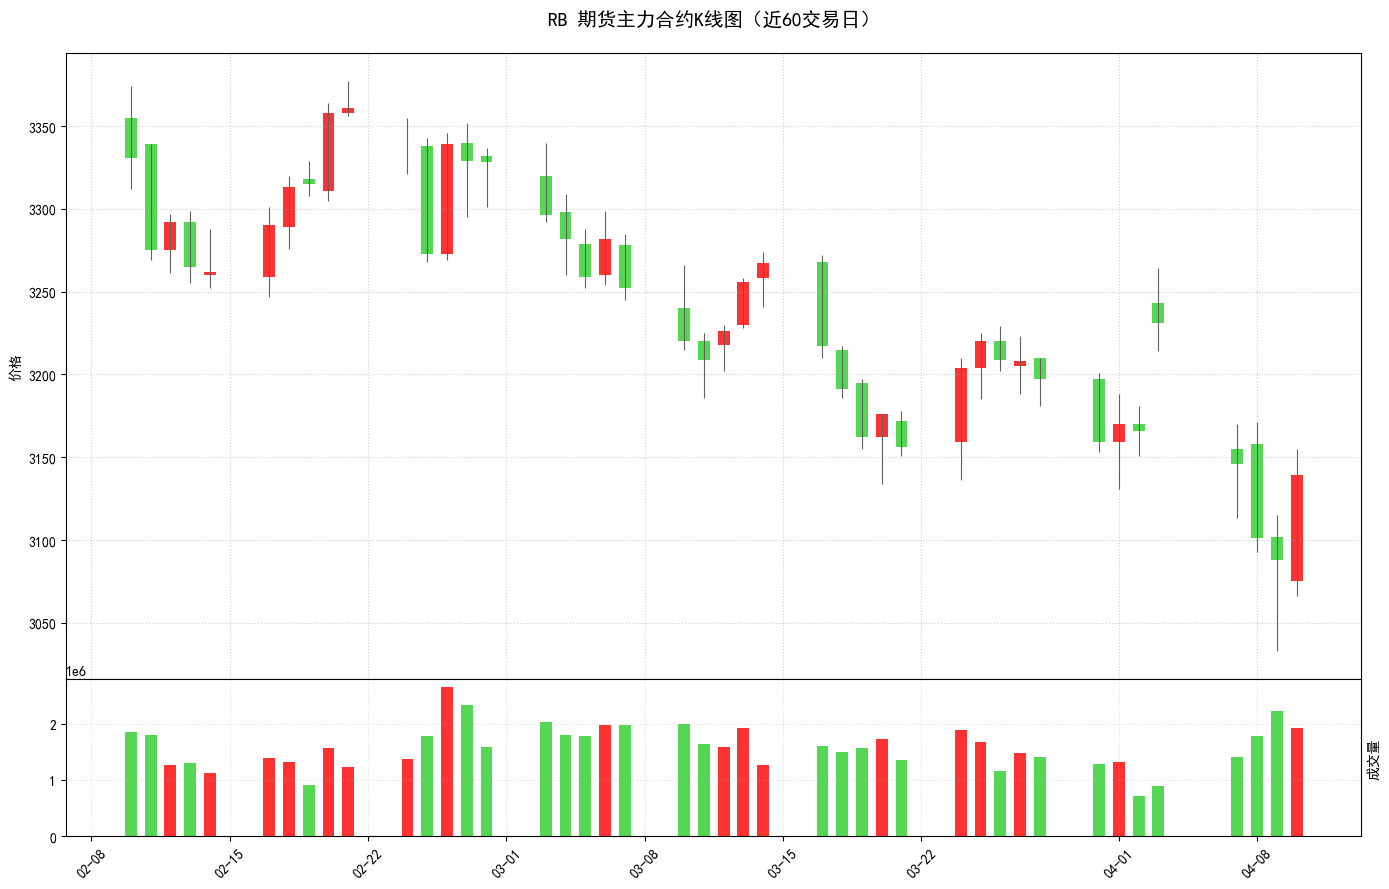

In [7]:
from matplotlib.patches import Rectangle

# 可视化期货K线图
def plot_futures_candle(df, symbol, days=60):
    """
    绘制期货K线图
    
    参数:
    data: 期货数据DataFrame
    symbol: 期货代码
    days: 显示最近多少天的数据
    """
    data= df.copy()
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data = data[['open','high','low','close','volume']]
    
    # 创建画布和子图
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(5, 1)
    ax_price = fig.add_subplot(gs[:4, 0])
    ax_volume = fig.add_subplot(gs[4, 0], sharex=ax_price)
    
    # 设置颜色（红涨绿跌）
    up_color = '#ff3232'  # 亮红色
    down_color = '#54d854' # 亮绿色
    wick_color = '#606060' # 灰色影线
    
    # 计算蜡烛参数
    candle_width = 0.6  # 蜡烛宽度（0-1）
    ohlc = data[['open','high','low','close']].values
    dates = mdates.date2num(data.index.to_pydatetime())  # 转换为matplotlib日期格式
    
    # 批量绘制K线（优化性能）
    for idx, (date, open_, high, low, close) in enumerate(zip(dates, *ohlc.T)):
        # 确定颜色
        color = up_color if close >= open_ else down_color
        
        # 绘制实体
        rect = Rectangle(
            (date - candle_width/2, min(open_, close)),
            candle_width,
            abs(close - open_),
            facecolor=color,
            edgecolor='none'
        )
        ax_price.add_patch(rect)
        
        # 绘制影线
        ax_price.vlines(
            x=date,
            ymin=low,
            ymax=high,
            colors=wick_color,
            linewidth=0.8
        )
    
    # 设置价格坐标轴
    ax_price.xaxis_date()  # 转换x轴为日期格式
    ax_price.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax_price.set_title(f'{symbol.rstrip("0")} 期货主力合约K线图（近{days}交易日）', fontsize=14, pad=20)
    ax_price.set_ylabel('价格', fontsize=10)
    ax_price.grid(True, linestyle=':', alpha=0.6)
    
    # 绘制成交量
    colors = [up_color if close >= open_ else down_color 
             for open_, close in zip(data['open'], data['close'])]
    ax_volume.bar(dates, data['volume'], 
                 color=colors, 
                 width=candle_width,
                 align='center')
    
    # 设置成交量坐标轴
    ax_volume.set_ylabel('成交量', fontsize=10)
    ax_volume.yaxis.set_label_position("right")
    ax_volume.grid(True, linestyle=':', alpha=0.4)
    
    # 自动调整日期标签
    plt.setp(ax_price.get_xticklabels(), visible=False)  # 隐藏价格图x标签
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    plt.show()

# 绘制螺纹钢K线图
if 'RB0' in multi_futures_data:
    plot_futures_candle(multi_futures_data['RB0'], 'RB0')

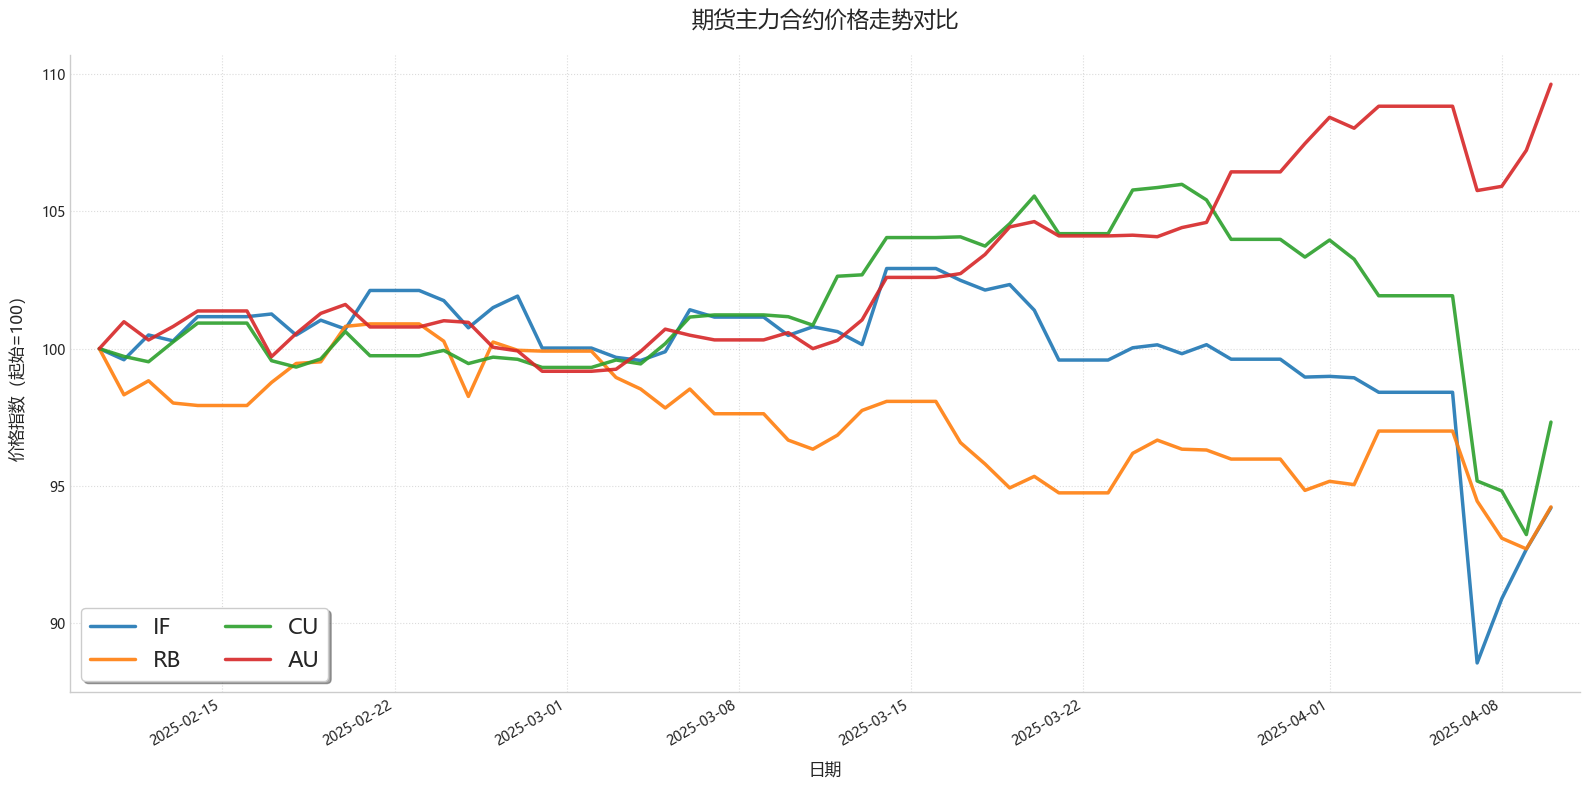

In [8]:
def plot_multi_futures_price(data_dict, title="期货品种价格走势对比"):
    """
    绘制多品种价格走势对比图（增强版）
    
    参数:
    data_dict: {品种代码: DataFrame}，每个DataFrame需包含'close'列和日期索引
    title: 图表标题（默认"期货品种价格走势对比"）
    """
    plt.figure(figsize=(16, 8))
    
    # 设置美观的样式
    plt.style.use('seaborn-v0_8-whitegrid')
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微软雅黑
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    
    # 获取最大时间范围
    all_dates = pd.DatetimeIndex([])
    for data in data_dict.values():
        if not data.empty:
            all_dates = all_dates.union(data.index)
    date_range = pd.date_range(start=all_dates.min(), end=all_dates.max())
    
    # 标准化价格走势并绘图
    for i, (symbol, data) in enumerate(data_dict.items()):
        if not data.empty:
            # 对齐时间序列
            data_reindexed = data.reindex(date_range, method='ffill')
            
            # 计算价格指数（考虑复权）
            normalized_price = data_reindexed['close'].ffill().dropna()
            if not normalized_price.empty:
                base_price = normalized_price.iloc[0]
                normalized_price = normalized_price / base_price * 100
                
                # 绘制曲线
                plt.plot(normalized_price.index, 
                        normalized_price.values,
                        label=f"{symbol.rstrip('0')}",
                        linewidth=2.5,
                        color=color_cycle[i % len(color_cycle)],
                        alpha=0.9)
    
    # 优化图表元素
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('日期', fontsize=12, labelpad=10)
    plt.ylabel('价格指数（起始=100）', fontsize=12, labelpad=10)
    
    # 改进图例
    leg = plt.legend(loc='lower left', 
                    ncol=2, 
                    frameon=True,
                    shadow=True,
                    fontsize=16)
    leg.get_frame().set_facecolor('white')
    
    # 设置坐标轴
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # 格式化日期轴
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.xticks(rotation=30, ha='right')
    
    # 设置网格和边距
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.margins(x=0.02)
    plt.tight_layout()
    plt.show()

for k,v in multi_futures_data.items():
    data = multi_futures_data[k]
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
# 示例使用（假设multi_futures_data包含多个品种数据）
plot_multi_futures_price(multi_futures_data, "期货主力合约价格走势对比")


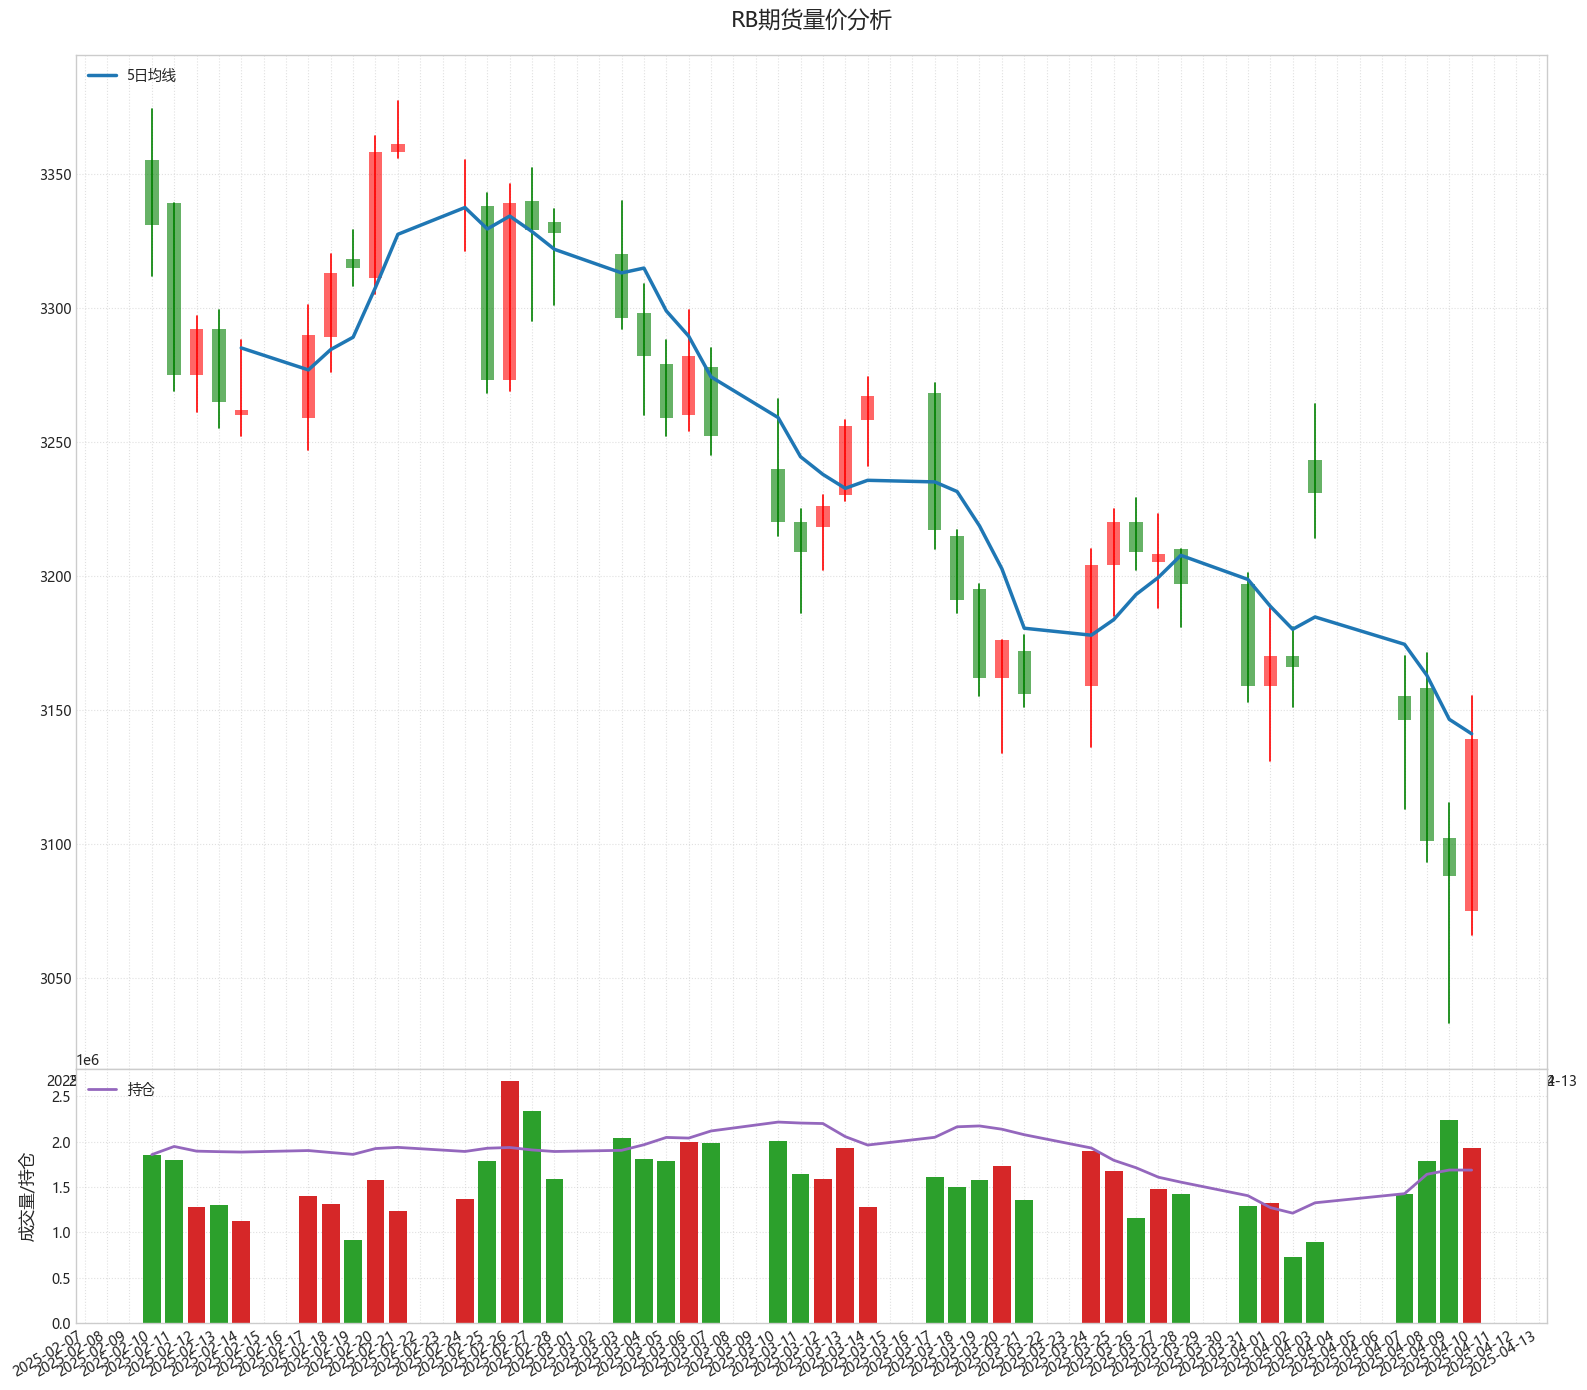

In [9]:
## 6. 期货成交量与持仓量分析

def plot_volume_and_holdings(df: pd.DataFrame, symbol):
    """
    量价分析图绘制

    Args:
        data (_type_): 必须包含列 ['open', 'high', 'low', 'close', 'volume', 'open_interest']
        symbol (_type_): 期货品种代码
    """
    data = df.copy()
    data.index = pd.to_datetime(data.index)
    trading_days = pd.Series(range(len(df)), index=data.index, name='trading_day')
    
    fig = plt.figure(figsize=(16,14))
    
    gs = fig.add_gridspec(5,1,hspace=0)
    ax_price = fig.add_subplot(gs[0:4, 0])
    ax_volume = fig.add_subplot(gs[4, 0], sharex=ax_price)
    #ax_oi = fig.add_subplot(gs[5, 0], sharex=ax_price)
    dates = mdates.date2num(data.index.to_pydatetime())
    
    for i, (date, row) in enumerate(data.iterrows()):
        color = 'red' if row['close'] >= row['open'] else 'green'
        
         # --- 绘制上下影线 ---
         # 当 X 轴坐标 完全相同 时，两点之间会形成一条 垂直线
        ax_price.plot(
            [dates[i], dates[i]],  # x位置（中心点）
            [row['low'], row['high']], 
            color=color,
            linewidth=1.2,
            zorder=1
        )
        
        # --- 使用Rectangle绘制实体 ---
        open_price = row['open']
        close_price = row['close']
        
        # 确定实体高度和位置
        height = abs(close_price - open_price)
        y = min(open_price, close_price)
        
        # 创建矩形对象
        rect = Rectangle(
            xy=(dates[i] - 0.6/2, y),  # 左下角坐标
            width=0.6,
            height=height,
            facecolor=color,
            edgecolor='none',  # 无边框
            alpha=0.6,
            zorder=2  # 确保实体在影线之上
        )
        
        # 将矩形添加到图表
        ax_price.add_patch(rect)
        
    # 绘制5日均线
    ma5 = data['close'].rolling(5).mean()
    ax_price.plot(dates, ma5.values,  # 使用转换后的日期数值
                color='#1f77b4', 
                linewidth=2.5,
                linestyle='-',
                label='5日均线',
                zorder=3)
    ax_price.set_title(f'{symbol.rstrip("0")}期货量价分析', 
                     fontsize=16, pad=20)
    ax_price.legend(loc='upper left', fontsize=10)
    ax_price.grid(True, linestyle=':', alpha=0.6)
    ax_price.xaxis_date()  # 将x轴转换为日期格式
    
    ax_volume.bar(dates, data['volume'], 
                color=['#d62728' if close >= open else '#2ca02c' 
                      for open, close in zip(data['open'], data['close'])],
                width=0.8)
    ax_volume.set_ylabel('成交量/持仓', fontsize=12, labelpad=10)
    ax_volume.plot(dates, data['open_interest'],color='#9467bd',linewidth=2.0, label="持仓")
    ax_volume.grid(True, linestyle=':', alpha=0.6)
    ax_volume.legend(loc='upper left', fontsize=10)
        
    ax_price.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax_price.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

# 绘制螺纹钢成交量与持仓量
if 'RB0' in multi_futures_data:
    plot_volume_and_holdings(multi_futures_data['RB0'], 'RB0')

In [10]:
import os, time

def download_and_save_futures_data(symbols, start_date, end_date=None, folder="./data", max_retries=3):
    """
    增强版期货数据下载与保存函数

    参数:
    symbols: 期货代码列表，例如 ['RB0', 'HC0']
    start_date: 开始日期 (格式自动识别)
    end_date: 结束日期 (默认当前日期)
    folder: 数据存储目录 (默认./data)
    max_retries: 失败重试次数 (默认3次)

    返回:
    下载结果报告字典
    """
    # 结果统计
    report = {
        'total': len(symbols),
        'success': 0,
        'failed': [],
        'saved_files': []
    }

    try:
        # 统一日期格式
        start_str = pd.to_datetime(start_date).strftime('%Y-%m-%d')
        end_str = pd.to_datetime(end_date or datetime.today()).strftime('%Y-%m-%d')
        
        # 创建数据目录（跨平台兼容）如果父目录不存在，会自动创建所有必要的父目录。
        os.makedirs(folder, exist_ok=True)
        
        # 添加进度条
        with tqdm(symbols, desc="下载期货数据") as pbar:
            for symbol in pbar:
                pbar.set_postfix_str(f"当前品种: {symbol}")
                retry_count = 0
                data = None
                
                # 带重试机制的数据获取
                while retry_count < max_retries:
                    try:
                        data = get_futures_daily_data(symbol, start_str, end_str)
                        if validate_data(data):
                            break
                        else:
                            raise ValueError("数据校验失败")
                    except Exception as e:
                        retry_count += 1
                        if retry_count >= max_retries:
                            tqdm.write(f"⚠️ {symbol} 数据获取失败: {str(e)}")
                            report['failed'].append({'symbol': symbol, 'error': str(e)})
                            break
                        time.sleep(2 ** retry_count)  # 指数退避
                
                if data is not None and not data.empty:
                    # 生成唯一文件名
                    filename = f"{symbol}_futures_{start_str}_to_{end_str}.csv"
                    filepath = generate_unique_path(os.path.join(folder, filename))
                    
                    # 保存数据
                    try:
                        data.to_csv(filepath, index_label='date')
                        report['success'] += 1
                        report['saved_files'].append(filepath)
                        tqdm.write(f"✅ {symbol} 数据已保存至 {filepath}")
                    except Exception as e:
                        report['failed'].append({'symbol': symbol, 'error': f"文件保存失败: {str(e)}"})
                        tqdm.write(f"⚠️ {symbol} 数据保存失败: {str(e)}")
    
    except Exception as e:
        print(f"‼️ 发生致命错误: {str(e)}")
    finally:
        print("\n下载报告:")
        print(f"总计品种: {report['total']}")
        print(f"成功下载: {report['success']}")
        print(f"失败数量: {len(report['failed'])}")
        if report['failed']:
            print("失败详情:")
            for item in report['failed']:
                print(f" - {item['symbol']}: {item['error']}")
        return report

def validate_data(data):
    """数据校验"""
    required_columns = ['open', 'high', 'low', 'close', 'volume']
    if data.empty:
        raise ValueError("空数据集")
    if not all(col in data.columns for col in required_columns):
        missing = [col for col in required_columns if col not in data.columns]
        raise ValueError(f"缺失必要列: {missing}")
    if data.isnull().sum().sum() > 0:
        raise ValueError("存在空值")
    return True

def generate_unique_path(path):
    """生成唯一文件名避免覆盖"""
    counter = 0
    base, ext = os.path.splitext(path)
    while os.path.exists(path):
        counter += 1
        path = f"{base}_{counter}{ext}"
    return path

# 使用示例
if __name__ == "__main__":
    selected_symbols = ['RB0', 'HC0', 'I0', 'JM0']
    download_report = download_and_save_futures_data(
        symbols=selected_symbols,
        start_date="2023-01-01",
        folder="./futures_data"
    )

下载期货数据:  25%|██▌       | 1/4 [00:00<00:02,  1.19it/s, 当前品种: HC0]  

✅ RB0 数据已保存至 ./futures_data\RB0_futures_2023-01-01_to_2025-04-10_1.csv


下载期货数据:  50%|█████     | 2/4 [00:01<00:01,  1.23it/s, 当前品种: I0]           

✅ HC0 数据已保存至 ./futures_data\HC0_futures_2023-01-01_to_2025-04-10_1.csv


下载期货数据:  75%|███████▌  | 3/4 [00:02<00:00,  1.24it/s, 当前品种: JM0]         

✅ I0 数据已保存至 ./futures_data\I0_futures_2023-01-01_to_2025-04-10_1.csv


下载期货数据: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, 当前品种: JM0]          

✅ JM0 数据已保存至 ./futures_data\JM0_futures_2023-01-01_to_2025-04-10_1.csv

下载报告:
总计品种: 4
成功下载: 4
失败数量: 0



期货品种风险指标分析:


,品种,总收益率(%),年化收益率(%),年化波动率(%),最大回撤(%),夏普比率,索提诺比率,交易日数
3,AU,9.63%,55.17%,14.15%,-2.82%,3.69,4.33,42
2,CU,-2.68%,-16.27%,23.61%,-12.04%,-0.82,-0.84,42
0,IF,-5.80%,-35.83%,30.42%,-13.96%,-1.28,-1.15,42
1,RB,-5.76%,-35.62%,16.58%,-8.12%,-2.33,-3.70,42


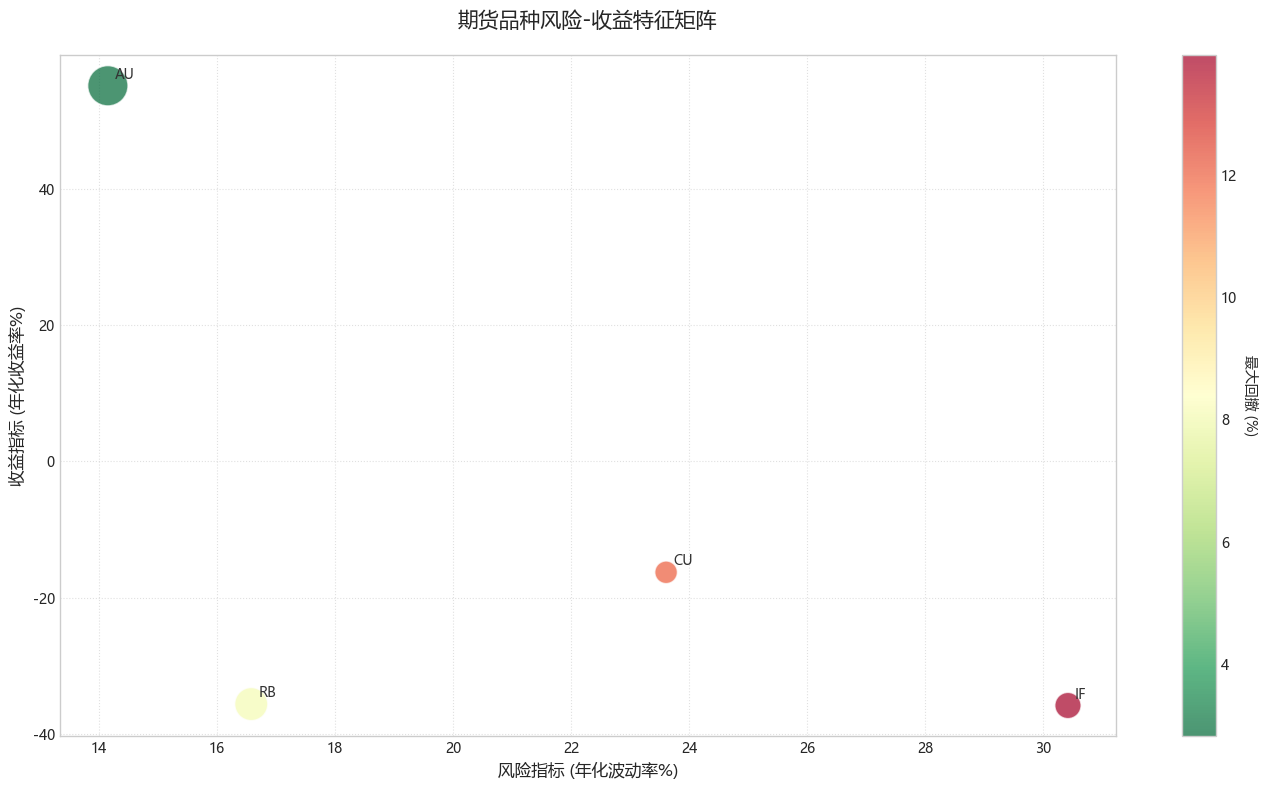

In [11]:
def calculate_futures_risk_metrics(data_dict, risk_free_rate=0.03):
    """
    增强版期货风险指标计算
    
    参数:
    data_dict: 包含各品种数据的字典，键为品种代码，值为DataFrame
    risk_free_rate: 无风险利率，默认3%
    
    返回:
    DataFrame: 包含风险指标的DataFrame
    """
    results = []
    
    for symbol, data in data_dict.items():
        if not data.empty and 'close' in data.columns:
            try:
                # 数据校验
                if len(data) < 5:
                    raise ValueError("数据不足5个交易日")
                
                # 计算收益率
                returns = data['close'].pct_change().dropna()
                
                # 计算累计收益
                total_return = (data['close'].iloc[-1] / data['close'].iloc[0] - 1) * 100
                
                # 计算年化参数
                trading_days = len(returns)
                annual_factor = np.sqrt(252 / trading_days) if trading_days > 0 else 0
                
                # 年化收益率（对数收益率）
                log_returns = np.log(data['close']).diff().dropna()
                annual_return = log_returns.mean() * 252 * 100
                
                # 年化波动率
                annual_volatility = log_returns.std() * np.sqrt(252) * 100
                
                # 最大回撤（优化算法）
                cumulative = (1 + returns).cumprod()
                peak = cumulative.expanding(min_periods=1).max()
                drawdown = (cumulative/peak - 1) * 100
                max_drawdown = drawdown.min()
                
                # 风险调整后收益指标
                sharpe_ratio = (annual_return/100 - risk_free_rate) / (annual_volatility/100) if annual_volatility != 0 else 0
                sortino_ratio = (annual_return/100 - risk_free_rate) / (log_returns[log_returns < 0].std() * np.sqrt(252)) if log_returns[log_returns < 0].std() != 0 else 0
                
                results.append({
                    '品种': symbol.rstrip('0'),
                    '总收益率(%)': round(total_return, 2),
                    '年化收益率(%)': round(annual_return, 2),
                    '年化波动率(%)': round(annual_volatility, 2),
                    '最大回撤(%)': round(max_drawdown, 2),
                    '夏普比率': round(sharpe_ratio, 2),
                    '索提诺比率': round(sortino_ratio, 2),
                    '交易日数': trading_days
                })
                
            except Exception as e:
                print(f"⚠️ {symbol} 指标计算失败: {str(e)}")
    
    return pd.DataFrame(results).sort_values('夏普比率', ascending=False)

# 计算风险指标
risk_metrics = calculate_futures_risk_metrics(multi_futures_data)

# 打印分析结果
print("\n期货品种风险指标分析:")
display(risk_metrics.style.format({
    '总收益率(%)': '{:.2f}%',
    '年化收益率(%)': '{:.2f}%',
    '年化波动率(%)': '{:.2f}%',
    '最大回撤(%)': '{:.2f}%',
    '夏普比率': '{:.2f}',
    '索提诺比率': '{:.2f}'
}).bar(subset=['夏普比率', '索提诺比率'], color='#5fba7d'))

# 风险收益可视化
plt.figure(figsize=(14, 8))

# 气泡图：大小表示夏普比率
scatter = plt.scatter(
    risk_metrics['年化波动率(%)'],
    risk_metrics['年化收益率(%)'],
    s=risk_metrics['夏普比率'].abs()*200 + 100,  # 气泡大小
    c=risk_metrics['最大回撤(%)'].abs(),
    cmap='RdYlGn_r',  # 红黄绿渐变色（反向）
    alpha=0.7,
    edgecolors='w'
)

# 添加标签
for i, row in risk_metrics.iterrows():
    plt.annotate(row['品种'], 
                (row['年化波动率(%)'], row['年化收益率(%)']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=10,
                color='#333333')

# 添加颜色条
cbar = plt.colorbar(scatter)
cbar.set_label('最大回撤 (%)', rotation=270, labelpad=15)

# 设置标题和标签
plt.title('期货品种风险-收益特征矩阵', fontsize=15, pad=20)
plt.xlabel('风险指标 (年化波动率%)', fontsize=12)
plt.ylabel('收益指标 (年化收益率%)', fontsize=12)

# 优化网格和布局
plt.grid(True, linestyle=':', alpha=0.6)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

In [14]:
list(pd.Series([1.0, 1.1, 1.2, 1.0, 0.9]).expanding(min_periods=1))

[0    1.0
 dtype: float64,
 0    1.0
 1    1.1
 dtype: float64,
 0    1.0
 1    1.1
 2    1.2
 dtype: float64,
 0    1.0
 1    1.1
 2    1.2
 3    1.0
 dtype: float64,
 0    1.0
 1    1.1
 2    1.2
 3    1.0
 4    0.9
 dtype: float64]